In [172]:
import alpaca_trade_api as alpaca
from datetime import datetime
from local_settings import alpaca_paper
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


ALPACA_API_KEY = alpaca_paper['api_key']
ALPACA_SECRET_KEY = alpaca_paper['api_secret']
END_POINT = alpaca_paper['url']
ALPACA_PAPER = True

api = alpaca.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, END_POINT)

In [173]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [174]:
def get_data(stock_symbol, data_source):
    if data_source == 'local':
        folder = '1000day_US/'
        if os.path.exists(folder+stock_symbol+'.json'):
            with open(folder+stock_symbol+'.json', encoding ='utf8') as json_file:
                stock_barset=json.load(json_file)
                stock_barset=stock_barset[stock_symbol]
        else:
            raise Exception("File does not exist")
    elif data_source == 'online':
        barset = api.get_barset(stock_symbol, 'day', limit = 1000)
        stock_barset = barset._raw[stock_symbol]
    else:
        raise Exception("data source unknown")
    return stock_barset

In [175]:
def get_volatility(stock_symbol, data_source, time_list):
    stock_barset = get_data(stock_symbol,data_source)
    
    # some parameters for the test
    gaps = time_list
    price_choice = 'c'
    
    # construct time sequence
    log_prices = [np.log(stock_barset[j][price_choice]) for j in range(len(stock_barset))]
    
    # initialization of the variance
    variance = [0] * len(gaps)
    for i, gap in enumerate(gaps):
        variance[i] = np.mean((np.array(log_prices[:-gap]) - np.array(log_prices[gap-1:-1]))**2)
    plt.plot(gaps, variance)
    return variance


In [176]:
def expectedROI(stock_symbol, data_source, time_limit, variance, direction, stop_loss_option):
    stock_barset = get_data(stock_symbol, data_source)
    
    if direction == 'short':
        for i in range(len(stock_barset)):
            stock_barset[i]['o'] = 1 / stock_barset[i]['o']
            stock_barset[i]['c'] = 1 / stock_barset[i]['c']
            tmp = stock_barset[i]['l']
            stock_barset[i]['l'] = 1 / stock_barset[i]['h']
            stock_barset[i]['h'] = 1 / tmp 
    
    stop_loss_pool = np.linspace(0.1, 5, 50)
    
    if stop_loss_option == 1:
        ROI = [[0]*50 for i in range(100)]
        take_profit_pool = np.linspace(0.05, 5, 100)
    
    # if trailing stop loss was used, turn off take_profit
    if stop_loss_option == 2:
        ROI = [0]*50
        take_profit_pool = [1]
    
    for i, tp in enumerate(take_profit_pool):
        for j, sl in enumerate(stop_loss_pool):
            take_profit = np.exp(tp * np.sqrt(variance))
            stop_loss = np.exp(-sl * np.sqrt(variance))
            
            # initialize gain and days
            gain = 1
            days = 0
            for k in range(len(stock_barset) - time_limit):
                buy_price = stock_barset[k]['c']
                highest_price = buy_price
                for time_gap in range(time_limit + 1):
                    if time_gap == time_limit:
                        gain = gain * (stock_barset[k + time_limit]['c'] / buy_price)
                        days = days + time_limit
                        break
                        highest_price = max(highest_price, stock_barset[k + time_gap + 1]['h'])
                    if stop_loss_option == 1:
                        # normal stop loss
                        if stock_barset[k + time_gap + 1]['l'] < stop_loss * buy_price:
                            gain = gain * stop_loss
                            days = days + time_gap + 1
                            break
                        if stock_barset[k + time_gap + 1]['h'] > take_profit * buy_price:
                            gain = gain * take_profit
                            days = days + time_gap + 1
                            break
                    if stop_loss_option == 2:
                        # trailing stop loss
                        if stock_barset[k + time_gap + 1]['l'] < stop_loss * highest_price:
                            gain = gain * highest_price / buy_price * stop_loss
                            days = days + time_gap + 1
                            break
            if stop_loss_option == 1:
                ROI[i][j] = gain**(1.0/days) - 1
            if stop_loss_option == 2:
                ROI[j] = gain**(1.0/days) - 1
    
    return ROI

In [188]:
def packed_search(stock_symbol, data_source, time_list, direction):
    variance = get_volatility(stock_symbol,data_source, time_list)
    plt.plot(time_list, variance)
    max_ROI = -100
    min_ROI = 100
    for i, gap in enumerate(time_list):
        ROI1 = expectedROI(stock_symbol, data_source, gap, variance[i], direction, 1)
        max_ROI = max(max_ROI, max(max(ROI1)))
        min_ROI = min(min_ROI, min(min(ROI1)))
        
        X, Y = np.meshgrid(np.linspace(0.1,5,50), np.linspace(0.05,5,100))
        plt.figure(figsize = (10,10))
        im = plt.pcolormesh(X,Y,ROI1,cmap='RdYlBu_r')
        plt.clim(vmin = -0.002, vmax = 0.002)
        ax = plt.gca()
        ax.set_aspect(1)
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_xticklabels([r'0',r'1',r'2',r'3',r'4',r'5'])
        ax.set_yticks([0,1,2,3,4,5])
        ax.set_yticklabels([r'0',r'1',r'2',r'3',r'4',r'5'])
        plt.xlabel(r'$l/\sigma$')
        plt.ylabel(r'$p/\sigma$')
        plt.title(f'(Max, Min) = ({max(max(ROI1)):.5f}, {min(min(ROI1)):.5f})')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
        plt.show
        plt.savefig(stock_symbol + '_' + str(gap) + 'd_' + direction + '_1.jpg')
        plt.close()
        
        ROI2 = expectedROI(stock_symbol, data_source, gap, variance[i], direction, 2)
        max_ROI = max(max_ROI, max(ROI2))
        min_ROI = min(min_ROI, min(ROI2))
        plt.figure(figsize = (10,10))
        plt.plot(np.linspace(0.1, 5, 50), ROI2)
        ax = plt.gca()
        #ax.set_aspect(1)
        plt.xlabel(r'$l/\sigma$')
        plt.show
        plt.savefig(stock_symbol + '_' + str(gap) + 'd_' + direction + '_2.jpg')
        plt.close()
    return max_ROI, min_ROI

packed_search('SPY', 'local', [1,2,5,10,22], 'long')

(0.0018512706218309916, -0.0022127246221734787)

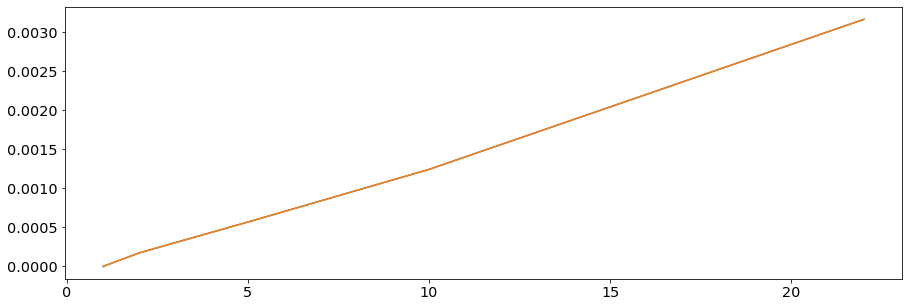

In [192]:
packed_search('SPY', 'local', [1,2,5,10,22], 'short')